In [1]:
#Загрузка даных:
from sklearn.datasets import fetch_20newsgroups
categories = ["comp.graphics","sci.space","rec.sport.baseball"]
df = fetch_20newsgroups(subset='train', categories=categories)
df1 = fetch_20newsgroups(subset='test', categories=categories)

In [2]:
#Функция чистки текста:
import pymorphy2
import re

def clean_text(text):
    morph = pymorphy2.MorphAnalyzer()
    text = text.replace("\\", " ").replace(u"╚", " ").replace(u"╩", " ")
    text = text.lower()
    text = re.sub('\-\s\r\n\s{1,}|\-\s\r\n|\r\n', '', text) #deleting newlines and line-breaks
    text = re.sub('[.,:;_%©?*,!@#$%^&()\d]|[+=]|[[]|[]]|[/]|"|\s{2,}|-', ' ', text) #deleting symbols  
    text = ' '.join(word for word in text.split() if len(word)>3)
    text = " ".join(morph.parse(word)[0].normal_form for word in text.split())
    
    return text

In [3]:
#Чистка текста и нахождение макс длины текста(или обрезание):
k=0
m=0
# Максимальное количество слов в самом длинном описании заявки
max_words = 0
for text in df.data:
    text=clean_text(text)
    df.data[k]=text
    words = len(text.split())
    if words > 500:
        df.data[k]=text[:500]
        words=500
        m=k
    if words > max_words:
        max_words = words
    k+=1

print('Максимальное количество слов в самом длинном описании заявки: {} слов'.format(max_words))

<ipython-input-2-2dfb3ff5ef30>:10: FutureWarning: Possible nested set at position 30
  text = re.sub('[.,:;_%©?*,!@#$%^&()\d]|[+=]|[[]|[]]|[/]|"|\s{2,}|-', ' ', text) #deleting symbols


Максимальное количество слов в самом длинном описании заявки: 500 слов


In [4]:
#Составление словаря
import pandas as pd
import numpy as np

from collections import Counter
vocab = Counter()
for text in df.data:
    for word in text.split(' '):
        vocab[word.lower()]=1
        
total_words = len(vocab)
print('Всего слов в словаре: ', total_words)

#Функция, которая возвращает индекс слова в словаре
def get_word_2_index(vocab):
    word2index = {}
    for i,word in enumerate(vocab):
        word2index[word.lower()] = i
        
    return word2index

word2index = get_word_2_index(vocab)

#Составление числовых векторов
batches = []
results = []
texts = df.data
categories = df.target

for text in texts:
    k=0
    layer = np.zeros(max_words,dtype=float)
    for word in text.split(' '):
        if (vocab[word.lower()])!=0:
            layer[k] = word2index[word.lower()]
            k+=1
            
    batches.append(layer)
X_train=np.array(batches)

#print(X_train[0],X_train.shape)

y=0
num_classes=3
target=np.zeros((num_classes))
y_train=np.zeros((len(df.target),num_classes))
for у in range(len(df.target)):
    #print(y,'= ',df.target[y])
    
    y_train[y,df.target[y]]=1
    target[df.target[y]]+=1
    #print(y,'= ',y_train[y])
    y+=1    

print('Распределение по рубликам: ',target)


#print(y_train[0],y_train.shape)


Всего слов в словаре:  20702
Распределение по рубликам:  [584. 597. 593.]


In [5]:
#Разбиение на обучающую и тестовую выборку
n=300
l=len(df.target)
X_test=X_train[l-n:l+1] 
y_test=y_train[l-n:l+1]
y_train=y_train[0:l-n]
X_train=X_train[0:l-n]
print('Размерность обучающей выборки: ',X_train.shape)
print('Размерность тестовой выборки: ',X_test.shape)

Размерность обучающей выборки:  (1474, 500)
Размерность тестовой выборки:  (300, 500)


In [13]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Activation
from keras.layers import Dropout

#Реккурентная модель
# максимальное количество слов для анализа
max_features = total_words
embedding_vector_length = 32
print(u'Собираем модель...')
model = Sequential()
#Слой для векторного представления слов
model.add(Embedding(total_words, embedding_vector_length, input_length=max_words))
#Слой долгосрочной памяти
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
#Полносвязный слой для классификации
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print (model.summary())

Собираем модель...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           662464    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 303       
Total params: 715,967
Trainable params: 715,967
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Activation
from keras.layers import Dropout,Conv1D,MaxPooling1D

# максимальное количество слов для анализа
max_features = total_words

print(u'Собираем модель...')
model = Sequential()
embedding_vector_length = 32
#Слой для векторного представления слов
model.add(Embedding(total_words, embedding_vector_length, input_length=max_words))
#одномерная свертка 1 слоя
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
#oбъединения для временных данных 1 слоя
model.add(MaxPooling1D(pool_size=2))
#одномерная свертка 2слоя
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
#oбъединения для временных данных 2слоя
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=7, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=9, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=12, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=15, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.3))
model.add(keras.layers.Dropout(0.3))
model.add(Dense(num_classes, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
   
print(model.summary())

Собираем модель...
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 32)           662464    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 32)           3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 250, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 250, 32)           4128      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 125, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 125, 32)           5152      
________________________________________

In [9]:
#Многослойный перcептрон
epochs = 10

print(u'Собираем модель...')
model = Sequential()
#Полносвязный слой для классификации
model.add(Dense(500, input_shape=(max_words,),activation='sigmoid'))
# Слой регуляризации Dropout
model.add(Dropout(0.2))
#Полносвязный слой для классификации
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Собираем модель...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 500)               250500    
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 1503      
Total params: 252,003
Trainable params: 252,003
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
#Обучение модели
batch_size = 32
epochs = 10

print(u'Тренируем модель...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test))

Тренируем модель...
Epoch 1/10
47/47 [==============================] - 48s 919ms/step - loss: 0.6625 - accuracy: 0.3531 - val_loss: 0.6394 - val_accuracy: 0.3133
Epoch 2/10
47/47 [==============================] - 48s 1s/step - loss: 0.6383 - accuracy: 0.3375 - val_loss: 0.6389 - val_accuracy: 0.3133
Epoch 3/10
47/47 [==============================] - 47s 990ms/step - loss: 0.6373 - accuracy: 0.3229 - val_loss: 0.6365 - val_accuracy: 0.3567
Epoch 4/10
34/47 [====================>.........] - ETA: 11s - loss: 0.6355 - accuracy: 0.3710

In [11]:
#Оценка модели
score = model.evaluate(X_test, y_test,
                       batch_size=batch_size, verbose=1)
print()
print(u'Оценка теста: {}'.format(score[0]))
print(u'Оценка точности модели: {}'.format(score[1]))

10/10 [==============================] - 0s 3ms/step - loss: 0.6341 - accuracy: 0.4267

Оценка теста: 0.6340540647506714
Оценка точности модели: 0.4266666769981384


In [24]:
#Получение прогноза от модели
import numpy as np
X_t[3]=np.zeros(500)
print(y_t)
prediction = model.predict(X_t)


j=0
for j in range(10):
    print("Текст № ",j+1)
    print('Правильная категория: ',np.argmax(y_t[j]))
    print("Определенная моделью категория: ",np.argmax(prediction[j]))

[[0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Текст №  1
Правильная категория:  2
Определенная моделью категория:  2
Текст №  2
Правильная категория:  1
Определенная моделью категория:  2
Текст №  3
Правильная категория:  2
Определенная моделью категория:  2
Текст №  4
Правильная категория:  1
Определенная моделью категория:  2
Текст №  5
Правильная категория:  2
Определенная моделью категория:  2
Текст №  6
Правильная категория:  3
Определенная моделью категория:  2
Текст №  7
Правильная категория:  3
Определенная моделью категория:  2
Текст №  8
Правильная категория:  1
Определенная моделью категория:  2
Текст №  9
Правильная категория:  2
Определенная моделью категория:  2
Текст №  10
Правильная категория:  3
Определенная моделью категория:  2


KeyError: 'acc'

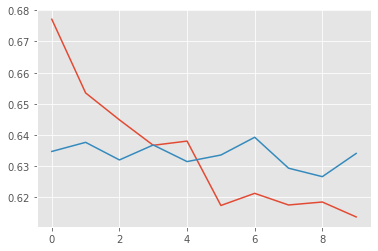

In [12]:
# Посмотрим на эффективность обучения
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Эффективность обучения")
plt.xlabel("Повторения #")
plt.ylabel("Ошибки")
plt.legend(loc="lower left")